In [26]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
import time
import os
from statistics import mean
import pandas as pd
import sklearn as sk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
device = None
try:
    c = torch.cuda.is_available()
    if c:
        print('devis: cuda')
        device = 'cuda'
    else:
        try :
            m = torch.backends.mps.is_available()
            if m:
                device = 'mps'
                print('devis: mps')  
        except:    
            device = 'cpu'
            print('devis: cpu')           
except:
    None

devis: mps


# **Import DataSets**

In [28]:
file = 'Input_DataSet_360x270' # [Input_DataSet_280x210,Input_DataSet_360x270]
input_data , labels = pickle.load(open(G_path + '/06_Rescaled_DataSet/'+ file,'rb'))
labels_biary = labels[1]
labels_multi = labels[0]

file = 'Input_DataSet_A_E' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/'+ file,'rb'))
A_E_labels_biary = A_E_labels[1]
A_E_labels_multi = A_E_labels[0]

file = 'Balanced_Test_Set_360x270' 
BLC_test = pickle.load(open(G_path + '/06_Rescaled_DataSet/' + file,'rb'))

file = 'Balanced_Test_Set_A_E' 
BLC_test_A_E = pickle.load(open(G_path + '/05_AutoEncoded_DataSet/' + file,'rb'))

Meta_Data_Augmented = pickle.load(open( G_path + '/02_Augmented_MetaData/Meta_Data_Augmented','rb'))

# **Import Model**

In [48]:
C_280 = 'CNN_280x210_MultiClassModel0_24_Jun22_22-38' # Best of grid search ['CNN_280x210_Model5_23_Jun22_12-55','CNN_280x210_Model4_22_Jun22_00-14]
C_280 = 'CNN_280x210_MultiClassModel1_12_Jul22_18_15'
C_280 = 'CNN_280x210_MultiClassModel41_14_Jul22_10_49'
C_280 = 'CNN_360x270_MultiClassModel14_15_Jul22_10_05'
C_280_binary = 'CNN_360x270_Binary_Model11_21_Jul22_06_50' #[CNN_360x270_Binary_Model11_21_Jul22_06_50,CNN_360x270_BinaryModel1_20_Jul22_12_45]

Model_multi = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280 , 'rb') ).eval()
Model_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/'+ C_280_binary , 'rb') ).eval()

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
A_E_binary = 'A_E_CNN_Model0_25_Jun22_09-35'
# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
Model_A_En_multiclass = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E , 'rb') ).eval()
Model_A_En_binary = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' + A_E_binary , 'rb') ).eval()

# **Model Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.8255528255528255


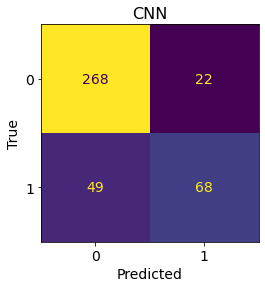

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,84.5%,92.4%,58.1%,88.3%
1,28.7%,75.6%,58.1%,92.4%,65.7%
Simple Avg.,nan%,80.0%,75.3%,75.3%,77.0%
Weighted Avg.,nan%,82.0%,82.6%,68.0%,81.8%


In [68]:
# Model 280x210
Evaluation_set = 2  #{train:0 , valid:1 , test:2}
balanced_test_set = False
binary_cnn = True
Multi_to_binary = False
model = Model_binary  # {Model_multi, CNN_A_En_multiclass}

if balanced_test_set:
    X = BLC_test[0]
    if binary_cnn:
        Y = BLC_test[2]
    else:
        Y = BLC_test[1]      
else:
    X = input_data[Evaluation_set]
    if binary_cnn:
        Y = labels_biary[Evaluation_set]
    else:
        Y = labels_multi[Evaluation_set]
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
Y_pred_prob = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n].detach()
    Y_prob = torch.softmax(model.forward_noDrop(X_),dim=1).detach()
    Y_ = model.forward_noDrop(X_).argmax(dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
    Y_pred_prob = torch.cat([Y_pred_prob,Y_prob]).detach()

if Multi_to_binary:
    Y_binary =  label_to_binary(Y)
    Y_pred_binary =  label_to_binary(Y_pred)
    results = model_evaluation(Y_binary,Y_pred_binary)
else:
    results = model_evaluation(Y,Y_pred,'CNN')
results

# **CNN: MultiClass/Binary: Get CNN OutPut (Soft-Max)**

In [50]:
Apply_SoftMax = True

model_ = Model_binary #[Model_multi, Model_binary]
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    if Apply_SoftMax:
        Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    else:
    # no SoftMax
        Y_ = model_.forward_noDrop(X_).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([5807, 3, 360, 270]), torch.Size([5807, 2]))

In [52]:
Y_pred.max(dim=0)

torch.return_types.max(
values=tensor([1.0000, 1.0000]),
indices=tensor([  87, 3397]))

In [84]:
def MinMax_Scaling(T):
    T_S = torch.zeros(0)
    for i in range(T.shape[0]):
        T_ = T[i:i+1]
        min = T_.min()
        max = T_.max()
        T_ = (T_ - min) / (max-min)
        T_S = torch.cat([T_S,T_]).detach()
    return T_S

In [85]:
Apply_scaling = True
if Apply_scaling:
    Y_pred = MinMax_Scaling(Y_pred)

In [43]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [13]:
# CNN_280x210_data.sample(100).drop(columns=['lesion_id','dx']).style.format({'CNN_0': "{:.1%}",'CNN_1': "{:.1%}",'CNN_2': "{:.1%}",'CNN_3': "{:.1%}",'CNN_4': "{:.1%}",'CNN_5': "{:.1%}",'CNN_6': "{:.1%}",'age': "{:0}"})

In [53]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_encoded = pd.get_dummies(CNN_280x210_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_encoded_STD = standardizaion(CNN_280x210_data_encoded,'age')

In [54]:
pickle.dump(CNN_280x210_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_360x270_Ouput_Binary_SoftMax', 'wb'))

# **CNN: AutoEncoder, Get CNN OutPut (Soft-Max)**

In [34]:
model_ = Model_A_En_multiclass
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 7]))

In [35]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [36]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [37]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_A_E_Ouput_MultiClass', 'wb'))

# **CNN: AutoEncoder Binary, Output**

In [38]:
model_ = Model_A_En_binary
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 2]))

In [39]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [40]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [41]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/07_CNNs_Output_DataSet/'+ 'CNN_A_E_Ouput_Binary', 'wb'))